In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import FinanceDataReader as fdr #pip3 install --user finance-datareader
from fredapi import Fred
import datetime, os

import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np


In [2]:
class SimEnv(object):
  tickers      = ['QQQ','GLD']
  ratios       = [0.5, 0.5]
  start_date   = '2018-10-30'
  end_date     = '2022-04-01'
  init_capital = 1_000_000

class SimPreprocessing(object):
  def __init__(self, env:SimEnv):
    df_price = self.preprocess(env.tickers)
    self.trading_df = self.make_trading_df(df_price, env.tickers)

  def get_trading_df(self):
    return self.trading_df

  def get_portpolio(self, tickers:list):
    yf.pdr_override()
    df_price = pdr.get_data_yahoo(tickers)
    df_price.isnull().sum()
    df_price.dropna(axis=0,inplace=True)
    return df_price

  def preprocess(self, tickers:list):
    df_price = self.get_portpolio(tickers)
    start = df_price.index[0] 
    end   = df_price.index[-1]
    df_new_index = pd.date_range(start,end)
    df_price = df_price.reindex(df_new_index)

    df_price.isna().sum()
    df_price.replace(np.NaN, 0, inplace=True)

    for today in df_price.index[1:]:
      for col in df_price.columns.values:
        if df_price[col][today] == 0:
          df_price[col][today] = df_price[col][today-datetime.timedelta(days=1)]
    return df_price

  def make_trading_df(self,df_price, tickers):
    trading_df = pd.DataFrame(df_price['Close'])
    trading_df[[etf+'_qty' for etf in tickers]]     = 0
    trading_df[[etf+'_capital' for etf in tickers]] = 0
    trading_df['Total'] = 0
    return trading_df

In [14]:
import datetime
from dateutil import relativedelta

class SimUtils(object):
  @staticmethod
  def get_pivot(year, month, day):
    pivot_date = datetime.datetime.strptime("%d-%d-%d"%(year,month,day), "%Y-%m-%d")
    return pivot_date

  @staticmethod
  def get_next_month(today:datetime):
      nextmonth = today + relativedelta.relativedelta(months=1)
      return nextmonth

  @staticmethod
  def set_reblancing_date(trading_df, start_date, end_date):
    tdf= trading_df.copy()
    tdf['Pivot'] = 0
    tdf.loc[start_date,'Pivot'] = 1
    tdf.loc[end_date,'Pivot'] = 1
    iter_date = start_date
    while iter_date < end_date:
      AW_4_  = (iter_date.month==4)
      AW_11_ = (iter_date.month==11)
      if (AW_4_ or AW_11_):
        pivot_date = SimUtils.get_pivot(iter_date.year,iter_date.month,28)
        tdf.loc[pivot_date,'Pivot'] = 1 
      iter_date = SimUtils.get_next_month(iter_date)
    return tdf

  @staticmethod
  def init_result_columns(trading_df, init_capital, tickers):
    capital = init_capital
    trading_df['Total'] = trading_df[[etf+'_capital' for etf in tickers]].sum(axis=1)
    trading_df['Yield'] = (trading_df['Total']-capital)/capital*100
    trading_df['MDD'] = 0
    return trading_df


class SimEngine(SimUtils):
  DEBUG = False
  def __init__(self, simenv:SimEnv, sim_preprocessing:SimPreprocessing):
    self.env = simenv
    self.env.start_date = datetime.datetime.strptime(simenv.start_date, '%Y-%m-%d')
    self.env.end_date   = datetime.datetime.strptime(simenv.end_date, '%Y-%m-%d')
    period     = (self.env.start_date <= sim_preprocessing.trading_df.index) & (self.env.end_date >= sim_preprocessing.trading_df.index)
    self.trading_df = sim_preprocessing.trading_df.loc[period]

  @staticmethod
  def buy_portpolio(trading_df, init_capital ,tickers):
    capital = init_capital
    ratios = [0.8, 0.2] 
    budgets = (np.ones(len(tickers))*capital)*ratios
    qtys   = (budgets/ trading_df.loc[trading_df.index[0],tickers].values).astype(int)

    for i, etf in enumerate(tickers):
      trading_df.loc[:,etf+'_qty'] = qtys[i] 
      trading_df[etf+'_capital'] = trading_df[etf+'_qty']*trading_df[etf]

    return trading_df

  def Run(self):
    env = self.env
    trading_df = SimUtils.set_reblancing_date(self.trading_df,self.env.start_date, self.env.end_date)
    trading_df = SimEngine.buy_portpolio(trading_df, env.init_capital, env.tickers)
    trading_df = SimUtils.init_result_columns(trading_df, env.init_capital, env.tickers)


    # Reblancing
    index = trading_df.loc[trading_df['Pivot']==True,:].index.values
    reference_column = 'Total' #'Yield'

    for i in range(len(index)-1):
      period = (index[i] <= trading_df.index) & (index[i+1] >= trading_df.index)
      quater_df = trading_df.loc[period,:].copy()
      if len(quater_df) == 0:
        break;

      quater_capital = 0
      for etf in env.tickers:
        quater_capital = quater_capital + quater_df.iloc[0].xs(etf+'_capital')
      quater_df = SimEngine.buy_portpolio(quater_df, quater_capital, env.tickers)
      quater_df = SimUtils.init_result_columns(quater_df,quater_capital,env.tickers)

      #peak
      peaks, _  = find_peaks(quater_df[reference_column])
      peaks2, _ = find_peaks(-quater_df[reference_column])

      if self.DEBUG:
        plt.plot(quater_df.index[peaks],quater_df[reference_column][peaks],'x')
        plt.plot(quater_df.index[peaks2],quater_df[reference_column][peaks2],'x')

      def MDD(quater_df, peaks, peaks2):
        high_df =  pd.DataFrame(peaks, columns=['val'])
        low_df  = pd.DataFrame(peaks2, columns=['val'])
        capital_df = quater_df[reference_column]

        for i in range(min(len(peaks),len(peaks2))-1):
          if capital_df[ high_df.loc[i].values[0] ] < capital_df[high_df.loc[i+1].values[0]]:
            high_df.iloc[i] = high_df.iloc[i+1]
            low_df.iloc[i] = low_df.iloc[i+1]
          else:
            high_df.iloc[i+1] = high_df.iloc[i]
            if capital_df[ low_df.loc[i].values[0] ] > capital_df[low_df.loc[i+1].values[0]]:
              low_df.iloc[i] = low_df.iloc[i+1]
            else:
              low_df.iloc[i+1] = low_df.iloc[i]

        peaks  = np.array(high_df.values).reshape(-1)
        peaks2 = np.array(low_df.values).reshape(-1)

        if len(peaks) == len(peaks2):
          diff =  1- (capital_df[peaks2].values/capital_df[peaks].values)
          period = list(zip(peaks,peaks2))
        elif len(peaks) < len(peaks2):
          diff = 1 - (capital_df[peaks2[:len(peaks)]].values/capital_df[peaks].values)
          period = list(zip(peaks,peaks2[:len(peaks)]))
        else:
          diff = 1 - (capital_df[peaks2].values /capital_df[peaks[:len(peaks2)]].values)
          period = list(zip(peaks[:len(peaks2)],peaks2))
        period = list(map(lambda x: ((capital_df.index[x[0]]<=capital_df.index) & (capital_df.index< capital_df.index[x[1]])), period))

        for i,p in enumerate(period):
          quater_df.loc[p,'MDD'] = -diff[i]

        quater_df['MDD']      = quater_df['MDD']*100
        quater_df['MDD_FULL'] = min(quater_df['MDD'])*100
        return quater_df

      quater_df = MDD(quater_df, peaks, peaks2)
      trading_df.loc[period,:] = quater_df

    trading_df[reference_column].plot()
    plt.legend()
    plt.show()

    return trading_df

In [15]:
simenv = SimEnv()
simenv.tickers      = ['QQQ','GLD']
simenv.ratios       = [0.5, 0.5]
simenv.start_date   = '2010-01-03'
simenv.end_date     = '2011-12-31'
simenv.init_capital = 1_000_000

simpp  = SimPreprocessing(simenv)
sim    = SimEngine(simenv, simpp)

[*********************100%***********************]  2 of 2 completed


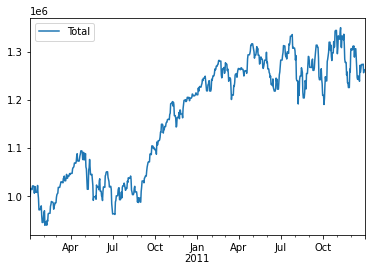

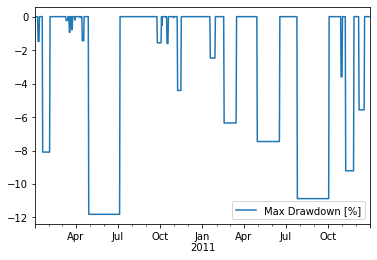

In [16]:
result_df = sim.Run()
result_df['MDD'].plot(label='Max Drawdown [%]')
plt.legend()
plt.show()